# Download Data

In [ ]:
!gdown 1TyyL4vZb3ksDInS6lj-q1QutA154a29F
!gdown 1tHLmGAV0SqMGMqkNij40VFZvlHqKyilz
!gdown 1wLxJvRGGiYq4_pXoqiYaQRGT5wQhC04f
!gdown 1k6kgwQEOBwkRDRTv2Bw-77UYZlbqk--n

Downloading...
From: https://drive.google.com/uc?id=1TyyL4vZb3ksDInS6lj-q1QutA154a29F
To: /content/test_images.npy
100% 73.1M/73.1M [00:00<00:00, 88.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tHLmGAV0SqMGMqkNij40VFZvlHqKyilz
To: /content/test_labels.npy
100% 47.7k/47.7k [00:00<00:00, 99.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1wLxJvRGGiYq4_pXoqiYaQRGT5wQhC04f
From (redirected): https://drive.google.com/uc?id=1wLxJvRGGiYq4_pXoqiYaQRGT5wQhC04f&confirm=t&uuid=e247c424-8c19-4fb8-a1e7-5e11302f6366
To: /content/train_images.npy
100% 298M/298M [00:03<00:00, 78.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k6kgwQEOBwkRDRTv2Bw-77UYZlbqk--n
To: /content/train_labels.npy
100% 194k/194k [00:00<00:00, 4.27MB/s]


In [ ]:
!pip install datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from datasets import Dataset, DatasetDict, Features, ClassLabel, Array3D

# Read Data

In [ ]:
train_X = np.load('train_images.npy')
train_y = np.load('train_labels.npy')
test_X = np.load('test_images.npy')
test_y = np.load('test_labels.npy')

In [ ]:
print("Train Images", train_X.shape)
print("Train Labels", train_y.shape)

Train Images (16175, 48, 48, 1)
Train Labels (16175, 3)


In [ ]:
labels = ["angry", "happy", "neutral"]

## Visualize Images

In [ ]:
def show(idx):
    plt.figure(figsize=(10, 6))
    plt.imshow(train_X[idx], cmap="gray")
    plt.title(labels[np.argmax(train_y[idx])])
    plt.axis("off")
    plt.show()

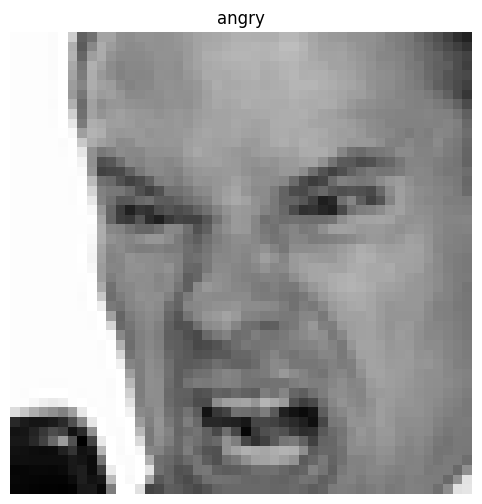

In [ ]:
show(np.random.randint(len(train_X)))

## Convert to HuggingFace dataset

In [ ]:
train_data = [{"image": img, "label": np.argmax(label)} for img, label in zip(train_X, train_y)]
test_data = [{"image": img, "label": np.argmax(label)} for img, label in zip(test_X, test_y)]

train_dataset = Dataset.from_list(train_data)
test_dataset = Dataset.from_list(test_data)

features = Features({
    "image": Array3D(dtype="float32", shape=(48, 48, 1)),
    "label": ClassLabel(num_classes=len(labels), names=labels),
})

train_dataset = train_dataset.cast(features)
test_dataset = test_dataset.cast(features)

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
})

print(dataset)

Casting the dataset:   0%|          | 0/16175 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3965 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 16175
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3965
    })
})


## Save Dataset

In [ ]:
dataset.save_to_disk("./FER_minimized_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/16175 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3965 [00:00<?, ? examples/s]

# Vision Transformer

In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor
from transformers import Trainer, TrainingArguments
from evaluate import load as load_metric
from datasets import Dataset, DatasetDict
import numpy as np
import torch

## Preprocess Data

In [ ]:
dataset = DatasetDict.load_from_disk('./FER_minimized_dataset')
labels = ["angry", "happy", "neutral"]

In [ ]:
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

def preprocess_data(examples):
    images = [np.stack([np.array(img).squeeze(-1)] * 3, axis=-1) for img in examples["image"]]
    inputs = feature_extractor(images=images, return_tensors="pt", do_rescale=False, )
    inputs["label"] = examples["label"]
    return inputs

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
dataset = dataset.map(preprocess_data, batched=True)

Map:   0%|          | 0/16175 [00:00<?, ? examples/s]

Map:   0%|          | 0/3965 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'pixel_values'],
        num_rows: 16175
    })
    test: Dataset({
        features: ['image', 'label', 'pixel_values'],
        num_rows: 3965
    })
})

## Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
).to(device)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./vit-finetuning",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
)

train_dataset = dataset["train"].with_format("torch")
test_dataset = dataset["test"].with_format("torch")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()
trainer.save_model("./vit-base-patch16-224-fer-minimized")

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.375181,0.860277
2,0.408800,0.360732,0.866835
3,0.408800,0.349936,0.877427
4,0.158800,0.385408,0.875410
5,0.158800,0.413196,0.871879


# Inference

In [ ]:
model = ViTForImageClassification.from_pretrained('./vit-base-patch16-224-fer')
inputs = feature_extractor(images=image, return_tensors="pt")


In [ ]:
outputs = model(**inputs)

In [ ]:
labels[outputs.logits.argmax()]

'happy'